# Unit 12 - Tales from the Crypto

---


## 1. Sentiment Analysis

Use the [newsapi](https://newsapi.org/) to pull the latest news articles for Bitcoin and Ethereum and create a DataFrame of sentiment scores for each coin.

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [1]:
# Initial imports
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from dotenv import load_dotenv
from newsapi import NewsApiClient
from collections import Counter

import nltk as nltk
from nltk import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import spacy
from spacy import displacy

nltk.download('vader_lexicon')
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = [20.0, 10.0]
analyzer = SentimentIntensityAnalyzer()
load_dotenv()

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\niker\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Read your api key environment variable
api_key = os.getenv("news_api")

In [3]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [4]:
# Fetch the Bitcoin news articles
# get_everything used instead of get_top_headlines since it does not fetch any data for any parameters
btc_news = newsapi.get_everything(q='bitcoin OR btc', language='en', sort_by='relevancy')

In [5]:
# Fetch the Ethereum news articles
# get_everything used instead of get_top_headlines since it does not fetch any data for any parameters
eth_news = newsapi.get_everything(q='ethereum OR eth NOT bitcoin', language='en', sort_by='relevancy')

In [6]:
# Create the Bitcoin sentiment scores DataFrame
btc_sentiments = []

for article in btc_news['articles']:
    try:
        sentiment = analyzer.polarity_scores(article['content'])

        btc_sentiments.append({
            'Date' : article['publishedAt'][:10],
            'Content' : article['content'],
            'Compound' : sentiment['compound'],
            'Positive' : sentiment['pos'],
            'Negative' : sentiment['neg'],
            'Neutral' : sentiment['neu']
        })
    except AttributeError:
        pass
    
btc_sentiment_df = pd.DataFrame(btc_sentiments)
btc_sentiment_df.head()

,Date,Content,Compound,Positive,Negative,Neutral
0,2021-10-06,How high are the chances of Bitcoin sustaining...,0.4939,0.219,0.000,0.781
1,2021-10-10,"Specifically, why did someone make a massive p...",0.5461,0.121,0.000,0.879
2,2021-10-20,Following SEC Chair Gary Gensler's landmark ap...,0.5994,0.198,0.057,0.745
3,2021-10-06,"<ul><li>Bitcoin, in terms of market value, ros...",0.3400,0.076,0.000,0.924
4,2021-10-28,Bitcoin. Sean Gladwell\r\nSean Gladwell\r\nCry...,0.4391,0.157,0.074,0.769


In [7]:
# Create the Ethereum sentiment scores DataFrame
eth_sentiments = []

for article in eth_news['articles']:
    try:
        sentiment = analyzer.polarity_scores(article['content'])

        eth_sentiments.append({
            'Date' : article['publishedAt'][:10],
            'Content' : article['content'],
            'Compound' : sentiment['compound'],
            'Positive' : sentiment['pos'],
            'Negative' : sentiment['neg'],
            'Neutral' : sentiment['neu']
        })
    except AttributeError:
        pass
    
eth_sentiment_df = pd.DataFrame(eth_sentiments)
eth_sentiment_df.head()

,Date,Content,Compound,Positive,Negative,Neutral
0,2021-10-07,"According to founder Vitalik Buterin, the Ethe...",0.000,0.000,0.0,1.000
1,2021-10-04,Dogecoin (CCC:DOGE-USD\r\n) sure knows how to ...,0.631,0.132,0.0,0.868
2,2021-10-12,Taoliang Wang is a visual designer based in Ch...,0.296,0.061,0.0,0.939
3,2021-10-11,"An immersive art installation, which will be c...",0.000,0.000,0.0,1.000
4,2021-10-12,Coinbase NFT\r\nRobert Nickelsberg/Getty Image...,0.000,0.000,0.0,1.000


In [8]:
# Describe the Bitcoin Sentiment
btc_sentiment_df.describe()

,Compound,Positive,Negative,Neutral
count,20.000000,20.00000,20.000000,20.000000
mean,0.235080,0.08155,0.028250,0.890200
std,0.311075,0.06678,0.038197,0.071432
min,-0.440400,0.00000,0.000000,0.745000
25%,0.000000,0.00000,0.000000,0.865250
50%,0.340000,0.08500,0.000000,0.893000
75%,0.481000,0.11650,0.058750,0.927750
max,0.599400,0.21900,0.116000,1.000000


In [9]:
# Describe the Ethereum Sentiment
eth_sentiment_df.describe()

,Compound,Positive,Negative,Neutral
count,20.000000,20.000000,20.000000,20.00000
mean,0.159205,0.054450,0.022900,0.92260
std,0.294068,0.060989,0.042771,0.08778
min,-0.361200,0.000000,0.000000,0.77300
25%,0.000000,0.000000,0.000000,0.84950
50%,0.000000,0.027000,0.000000,0.96950
75%,0.349650,0.114500,0.012000,1.00000
max,0.700300,0.146000,0.125000,1.00000


### Questions:

Q: Which coin had the highest mean positive score?

A: Bitcoin

Q: Which coin had the highest compound score?

A: Ethereum

Q. Which coin had the highest positive score?

A: Bitcoin

Q. Which coin had the highest negative score?

A: Ethereum

---

## 2. Natural Language Processing
---
###   Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word.
2. Remove Punctuation.
3. Remove Stopwords.

In [10]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
stop_words = set(stopwords.words('english'))

# Expand the default stopwords list if necessary
stop_words_addon = {'https', 
                    'reuters', 
                    'U.Today', 
                    'oct',
                    'exchange',
                    'utoday',
                    'reutersdado',
                    'october',
                    'following',
                    'user',
                    'according',
                    'appreciationfrom',
                    'exchangetraded',
                    'representation',
                    'httpsifttteavj',
                    'wednesday',
                    'currently',
                    'fund',
                    'char', 
                    'chars', 
                    'SuSINGAPORE', 
                    'ha', 
                    'might', 
                    'well', 
                    'via', 
                    'vs', 
                    'hi',
                    'co',
                    'seen',
                    'taken',
                    'day',
                    'new',
                    'us',
                    'week',
                    'illustration',
                    'year',
                    'may',
                    'one',
                    'high',
                    'first'}

In [11]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    
    # Remove the punctuation from text
    regex = re.compile("[^a-zA-Z ]")
    clean_text = regex.sub('', text)
   
    # Create a tokenized list of the words
    words = word_tokenize(clean_text)
    
    # Lemmatize words into root words
    lem_words = [lemmatizer.lemmatize(word) for word in words]
   
    # Convert the words to lowercase
    lower_words = [word.lower() for word in lem_words]
    
    # Remove the stop words
    tokens = [word for word in lower_words if word not in stop_words.union(stop_words_addon)]
    
    return tokens

In [12]:
# Create a new tokens column for Bitcoin
btc_tokens = []

for article in btc_sentiment_df['Content']:
    btc_tokens.append(tokenizer(article))
    
btc_sentiment_df['BTC_Tokens'] = pd.Series(btc_tokens)
btc_sentiment_df.head()

,Date,Content,Compound,Positive,Negative,Neutral,BTC_Tokens
0,2021-10-06,How high are the chances of Bitcoin sustaining...,0.4939,0.219,0.000,0.781,"[chance, bitcoin, sustaining, gain, pushing, a..."
1,2021-10-10,"Specifically, why did someone make a massive p...",0.5461,0.121,0.000,0.879,"[specifically, someone, make, massive, purchas..."
2,2021-10-20,Following SEC Chair Gary Gensler's landmark ap...,0.5994,0.198,0.057,0.745,"[sec, chair, gary, genslers, landmark, approva..."
3,2021-10-06,"<ul><li>Bitcoin, in terms of market value, ros...",0.3400,0.076,0.000,0.924,"[ullibitcoin, term, market, value, rose, lilii..."
4,2021-10-28,Bitcoin. Sean Gladwell\r\nSean Gladwell\r\nCry...,0.4391,0.157,0.074,0.769,"[bitcoin, sean, gladwellsean, gladwellcrypto, ..."


In [13]:
# Get all the tokens from all the articles for Bitcoin
btc_all_articles = ' '.join(btc_sentiment_df['Content'])
btc_tokens = tokenizer(btc_all_articles)

In [14]:
# Create a new tokens column for Ethereum
eth_tokens = []

for article in eth_sentiment_df['Content']:
    eth_tokens.append(tokenizer(article))
    
eth_sentiment_df['ETH_Tokens'] = pd.Series(eth_tokens)
eth_sentiment_df.head()

,Date,Content,Compound,Positive,Negative,Neutral,ETH_Tokens
0,2021-10-07,"According to founder Vitalik Buterin, the Ethe...",0.000,0.000,0.0,1.000,"[founder, vitalik, buterin, ethereumcrypto, et..."
1,2021-10-04,Dogecoin (CCC:DOGE-USD\r\n) sure knows how to ...,0.631,0.132,0.0,0.868,"[dogecoincccdogeusd, sure, know, keep, head, w..."
2,2021-10-12,Taoliang Wang is a visual designer based in Ch...,0.296,0.061,0.0,0.939,"[taoliang, wang, visual, designer, based, chan..."
3,2021-10-11,"An immersive art installation, which will be c...",0.000,0.000,0.0,1.000,"[immersive, art, installation, converted, nfts..."
4,2021-10-12,Coinbase NFT\r\nRobert Nickelsberg/Getty Image...,0.000,0.000,0.0,1.000,"[coinbase, nftrobert, nickelsberggetty, images..."


In [15]:
# Get all the tokens from all the articles for Ethereum
eth_all_articles = ' '.join(eth_sentiment_df['Content'])
eth_tokens = tokenizer(eth_all_articles)

---

### NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [16]:
# Generate the Bitcoin N-grams where N=2
btc_bigram = ngrams(btc_tokens, n=2)

In [17]:
# Generate the Ethereum N-grams where N=2
eth_bigram = ngrams(eth_tokens, n=2)

In [18]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [19]:
# Use token_count to get the top 10 words for Bitcoin - Based on Bigram(n=2)
token_count(btc_bigram)

[(('price', 'bitcoin'), 2),
 (('bitcoin', 'future'), 2),
 (('future', 'etf'), 2),
 (('chance', 'bitcoin'), 1),
 (('bitcoin', 'sustaining'), 1),
 (('sustaining', 'gain'), 1),
 (('gain', 'pushing'), 1),
 (('pushing', 'altcoins'), 1),
 (('altcoins', 'higherfrom'), 1),
 (('higherfrom', 'httpsiftttbkdpx'), 1)]

In [20]:
# Use token_count to get the top 10 words for Bitcoin
token_count(btc_tokens)

[('bitcoin', 19),
 ('etf', 8),
 ('price', 5),
 ('cryptocurrency', 3),
 ('growing', 3),
 ('trading', 3),
 ('gain', 2),
 ('signal', 2),
 ('sec', 2),
 ('approval', 2)]

In [21]:
# Use token_count to get the top 10 words for Ethereum - Based on Bigram(n=2)
token_count(eth_bigram)

[(('founder', 'vitalik'), 2),
 (('vitalik', 'buterin'), 2),
 (('buterin', 'ethereumcrypto'), 2),
 (('ethereumcrypto', 'eth'), 2),
 (('eth', 'network'), 2),
 (('network', 'verge'), 2),
 (('verge', 'dramatic'), 2),
 (('dramatic', 'technological'), 2),
 (('technological', 'revolution'), 2),
 (('revolution', 'ethereum'), 2)]

In [22]:
# Use token_count to get the top 10 words for Ethereum
token_count(eth_tokens)

[('ethereum', 5),
 ('nft', 4),
 ('eth', 3),
 ('crypto', 3),
 ('nfts', 3),
 ('founder', 2),
 ('vitalik', 2),
 ('buterin', 2),
 ('ethereumcrypto', 2),
 ('network', 2)]

---

### Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

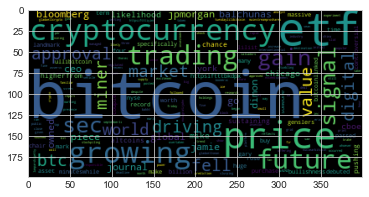

In [23]:
# Generate the Bitcoin word cloud
wc = WordCloud().generate(' '.join(btc_tokens))
plt.imshow(wc)

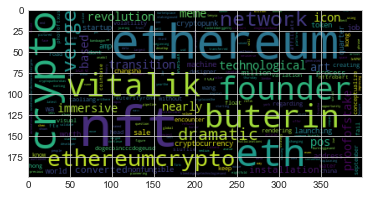

In [24]:
# Generate the Ethereum word cloud
wc = WordCloud().generate(' '.join(eth_tokens))
plt.imshow(wc)

---
## 3. Named Entity Recognition

In this section, you will build a named entity recognition model for both Bitcoin and Ethereum, then visualize the tags using SpaCy.

In [25]:
# Download the language model for SpaCy
# !python -m spacy download en_core_web_sm

In [26]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

---
### Bitcoin NER

In [27]:
# Concatenate all of the Bitcoin text together
btc_big_string = ' '.join(btc_sentiment_df['Content'])

In [28]:
# Run the NER processor on all of the text
btc_doc = nlp(btc_big_string)

# Add a title to the document
btc_doc.user_data['title'] = 'Bitcoin NER Visualization'

In [29]:
# Render the visualization
displacy.render(btc_doc, style='ent')

In [30]:
# List all Entities
print([ent.text for ent in btc_doc.ents])

['$1.6 billion', 'Wednesday', 'a couple of minutes', 'SEC', "Gary Gensler's", 'first', 'NYSE', 'this week', '4.6%', '53,859.6.</li><li', '50,000', 'first', 'four weeks', 'Tuesday', '50,000', 'Sean Gladwell', 'Sean Gladwell', 'Crypto', 'This Wednesday', '55,000', 'five months', 'close to 10%', 'just a few hours', 'JPMorgan', 'Jamie Dimon', 'Friday, October 16', 'first', 'U.S.', 'ProShares', 'first', "El Salvador's", '11%', 'the first day', 'the days', 'Bit', 'U.S.', 'U.S.', 'China', 'The Fine Print', 'Last week', 'the Wall Street Journal', 'three', 'Journal', 'Bakkt Holdings Inc.', 'the first day', 'The Intercontinental Exchange', 'Bloomberg', 'Eric Balchunas', 'SEC', 'Eric Balchunas', 'Mike Novogratz', 'John Lamparski', 'Mike Novogratz', "Jamie Dimon's", 'JPMorgan', 'Tuesday', 'the New York Stock Exchange', 'ETF', 'the Securities and Exchange Co', 'first', 'this week', 'Jonathan Manzi', 'Bitcoin', 'Bloomberg', 'the National Bureau', 'Chicago Board Options Exchange', 'CBOE', 'Chicago', 

---

### Ethereum NER

In [31]:
# Concatenate all of the Ethereum text together
eth_big_string = ' '.join(eth_sentiment_df['Content'])

In [32]:
# Run the NER processor on all of the text
eth_doc = nlp(eth_big_string)

# Add a title to the document
eth_doc.user_data['title'] = 'Ethereum NER Visualization'

In [33]:
# Render the visualization
displacy.render(eth_doc, style='ent')

In [34]:
# List all Entities
print([ent.text for ent in eth_doc.ents])

['Vitalik Buterin', 'One year from now', 'Ethereum', 'Dogecoin\xa0', 'CCC', 'DOGE-USD\r\n', 'Taoliang Wang', 'Changsha', 'China', '100', 'Ethereum', 'Hong Kong', 'September 30, 2021', 'FTX', 'NFT', 'Robert Nickelsberg', 'Getty Images', 'Coinbase Global', 'NFT', 'the end of the year', 'US', 'Vitalik Buterin', 'One year from now', 'Ethereum', 'Thursday', '6:13 p.m.', 'New York', 'Ethereum', 'CryptoPunk', '0x8e39', 'Richerd Chen', 'Canadian', 'CryptoPunkNFT', '2,500', 'nearly $9.5 million', 'USD', 'Matt Damon', 'Rokas Tenys', 'NFT', 'over $532 million', 'this week', 'Machine Hallucinations Space', 'Refik Anadol', 'NFT', 'LONDON', 'Oct 4', 'Reuters', '$10.7 billion', 'the third quarter of 2021', 'the previous quarter', 'Paul', 'Weiss', 'Rifkind', 'Wharton &amp', 'Garrison LLP', 'Lipton, Rosen &amp', 'Katz', 'one', 'NFT', 'two', 'Introducing LEONARDO', 'Compound', 'Ethereum', 'Sashkin', 'GameStop', 'eight']


---